In [1]:
import pandas as pd
from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
import nltk
from gensim.corpora import Dictionary
from nltk.util import everygrams
from gensim.models.ldamodel import LdaModel
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.topic_coherence import direct_confirmation_measure
from my_custom_module import custom_log_ratio_measure
import pyLDAvis.gensim_models
import pyLDAvis
import copy
import time
pyLDAvis.enable_notebook()
direct_confirmation_measure.log_ratio_measure = custom_log_ratio_measure
!pip install stop-words
%matplotlib inline

In [2]:
FILE_ORIGIN = '../dblpv13.json'
FILE_PREPROCESSED = '../data.json'

In [3]:
CHUNKSIZE = 100000
MAX_OBSERVATIONS = 1000000 #Set to 55000000 if want all rows
df = pd.DataFrame()
with pd.read_json(FILE_PREPROCESSED, orient='records', lines=True, chunksize=CHUNKSIZE, nrows=MAX_OBSERVATIONS) as reader:
    for chunk_i, chunk in tqdm_notebook(enumerate(reader), total=MAX_OBSERVATIONS // CHUNKSIZE):
        df_new = pd.DataFrame(chunk)
        df_new['chunk_idx'] = chunk_i
        df = pd.concat([df, df_new], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
df.head()

_id  \
0  53e99784b7602d9701f3e3f5   
1  53e99784b7602d9701f3e133   
2  53e99784b7602d9701f3e151   
3  53e99784b7602d9701f3e15d   
4  53e99784b7602d9701f3e161   

                                               title  \
0                                              3GIO.   
1  The relationship between canopy parameters and...   
2  A solution to the problem of touching and brok...   
3  Timing yield estimation using statistical stat...   
4                                               360°   

                                               venue    year  \
0                                        {'type': 0}  2011.0   
1  {'_id': '53a7297d20f7420be8bd4ae7', 'name_d': ...  2011.0   
2  {'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...  1993.0   
3  {'_id': '53a72e2020f7420be8c80142', 'name_d': ...  2005.0   
4  {'_id': '5390a74a20f70186a0e8b40b', 'raw': 'AC...  2009.0   

                                            keywords  n_citation lang  \
0                                                 []         0.0   en   
1  [canopy parameters, canopy spectrum, different...         0.0   en   
2  [handwriting recognition, prototypes, image se...        17.0   en   
3  [sequential circuits, statistical distribution...        28.0   en   
4  [global high technology, daily short-distance ...         NaN   en   

                                             authors  \
0                                                NaN   
1  [{'_id': '53f45728dabfaec09f209538', 'name': '...   
2  [{'_id': '53f46797dabfaeb22f542630', 'name': '...   
3  [{'_id': '53f43b03dabfaedce555bf2a', 'name': '...   
4  [{'_id': '53f46946dabfaec09f24b4ed', 'name': '...   

                                                 fos page_start  ... volume  \
0                                                NaN        NaN  ...    NaN   
1  [Agronomy, Moisture, Hydrology, Environmental ...       1930  ...   null   
2  [Intelligent character recognition, Pattern re...        602  ...          
3  [Delay calculation, Timing failure, Monte Carl...       2461  ...          
4                                                NaN         39  ...          

  issue issn           isbn                          doi  \
0   NaN  NaN            NaN                          NaN   
1  null                      10.1109/IGARSS.2011.6049503   
2                              10.1109/ICDAR.1993.395663   
3             0-7803-8834-8   10.1109/ISCAS.2005.1465124   
4                                10.1145/1665137.1665166   

                                                 pdf  \
0                                                NaN   
1                                               None   
2                                               None   
3  //static.aminer.org/pdf/PDF/000/423/329/timing...   
4                                                NaN   

                                                 url  \
0                                                NaN   
1    [http://dx.doi.org/10.1109/IGARSS.2011.6049503]   
2      [http://dx.doi.org/10.1109/ICDAR.1993.395663]   
3  [http://dx.doi.org/10.1109/ISCAS.2005.1465124,...   
4                                                NaN   

                                            abstract  \
0                                                NaN   
1  Drought is the first place in all the natural ...   
2                                                      
3  As process variations become a significant pro...   
4  360° represents the concerns that are addresse...   

                                          references chunk_idx  
0                                                NaN         0  
1                                                NaN         0  
2  [53e99cf5b7602d97025ace63, 557e8a7a6fee0fe990c...         0  
3  [53e9a8a9b7602d97031f6bb9, 599c7b6b601a182cd27...         0  
4                                                NaN         0  

[5 rows x 21 columns]

In [5]:
df.lang.value_counts()

en    999914
zh        86
Name: lang, dtype: int64

# Data Preprocessing

In [6]:
df['title_abst'] = df['title'] + ' ' + df['abstract']

In [7]:
df_en = df[df.lang.eq('en')]

In [8]:
class GensimBoW:
    def __init__(self, min_freq_abs=1, max_freq=0.8, keep_words=100000, ngram=2):
        self.stop_word = set(nltk.corpus.stopwords.words('english'))
        self.dictionary = Dictionary()
        self.ps = nltk.stem.PorterStemmer()
        self.min_freq_abs = min_freq_abs
        self.max_freq = max_freq
        self.keep_words = keep_words
        self.ngram = ngram

    @staticmethod
    def _docs_to_words(docs):
        for doc in docs:
            yield(gensim.utils.simple_preprocess(str(doc), deacc=True))

    def _stemme(self, token):
        return self.ps.stem(token)
    
    def _check(self, token):
        return token not in self.stop_word

    def _ngrams(self, tokens):
        if self.ngram == 1:
            return tokens
        return (' '.join(a) for a in everygrams(tokens, max_len=self.ngram))

    def _filter_extremes(self):
        self.dictionary.filter_extremes(no_below=self.min_freq_abs, 
                                        no_above=self.max_freq, 
                                        keep_n=self.keep_words)
        self.dictionary.compactify()
    
    def _create_dictionary(self, X):
        for doc in tqdm_notebook(self._docs_to_words(X), total=len(X)):
            start = time.time()
            filtered_doc = [self._stemme(token) for token in doc if self._check(token)]
            self.dictionary.add_documents([self._ngrams(filtered_doc)])
            stop = time.time()
            if stop - start > 1:
                print('dict is filtered')
                self._filter_extremes()
        self._filter_extremes()

    def _get_BoW_corpus(self, X):
        BoW_corpus = []
        self._filtered_docs = []
        for doc in tqdm_notebook(self._docs_to_words(X), total=len(X)):
            filtered_doc = [self._stemme(token) for token in doc if self._check(token)]
            self._filtered_docs.append(filtered_doc)
            BoW_corpus.append(self.dictionary.doc2bow(self._ngrams(filtered_doc), allow_update=False))
        return BoW_corpus
    
    def fit(self, X, y=None):
        self._create_dictionary(X)
        return self

    def transform(self, X):
        return self._get_BoW_corpus(X)

In [9]:
BoW_model_titles = GensimBoW(keep_words=30000, min_freq_abs=1)

In [10]:
BoW_model_titles.fit(df_en['title'])
print(f'Titles Dictionary: {len(BoW_model_titles.dictionary)}')

  0%|          | 0/999914 [00:00<?, ?it/s]

Titles Dictionary: 30000


In [11]:
BoW_model_abst = GensimBoW(keep_words=100000, min_freq_abs=1)
BoW_model_abst.fit(df_en['abstract'])
print(f'Abstracts Dictionary: {len(BoW_model_abst.dictionary)}')

  0%|          | 0/999914 [00:00<?, ?it/s]

dict is filtered
dict is filtered
dict is filtered
dict is filtered
dict is filtered
dict is filtered
dict is filtered
dict is filtered
dict is filtered
dict is filtered
Abstracts Dictionary: 100000


In [12]:
BoW_model_title_abst_dictionary = copy.deepcopy(BoW_model_abst.dictionary)

In [13]:
BoW_model_title_abst = GensimBoW()
BoW_model_title_abst_dictionary.merge_with(BoW_model_titles.dictionary)
BoW_model_title_abst.dictionary = BoW_model_title_abst_dictionary

In [14]:
print(f'Titles Dictionary: {len(BoW_model_titles.dictionary)}')
print(f'Abstracts Dictionary: {len(BoW_model_abst.dictionary)}')
print(f'Final Dictionary: {len(BoW_model_title_abst.dictionary)}')

Titles Dictionary: 30000
Abstracts Dictionary: 100000
Final Dictionary: 105215


In [15]:
del BoW_model_abst

In [16]:
del BoW_model_titles

In [17]:
BoW = BoW_model_title_abst.transform(df_en['title_abst'])

  0%|          | 0/999914 [00:00<?, ?it/s]

# Models

c_v understanding: 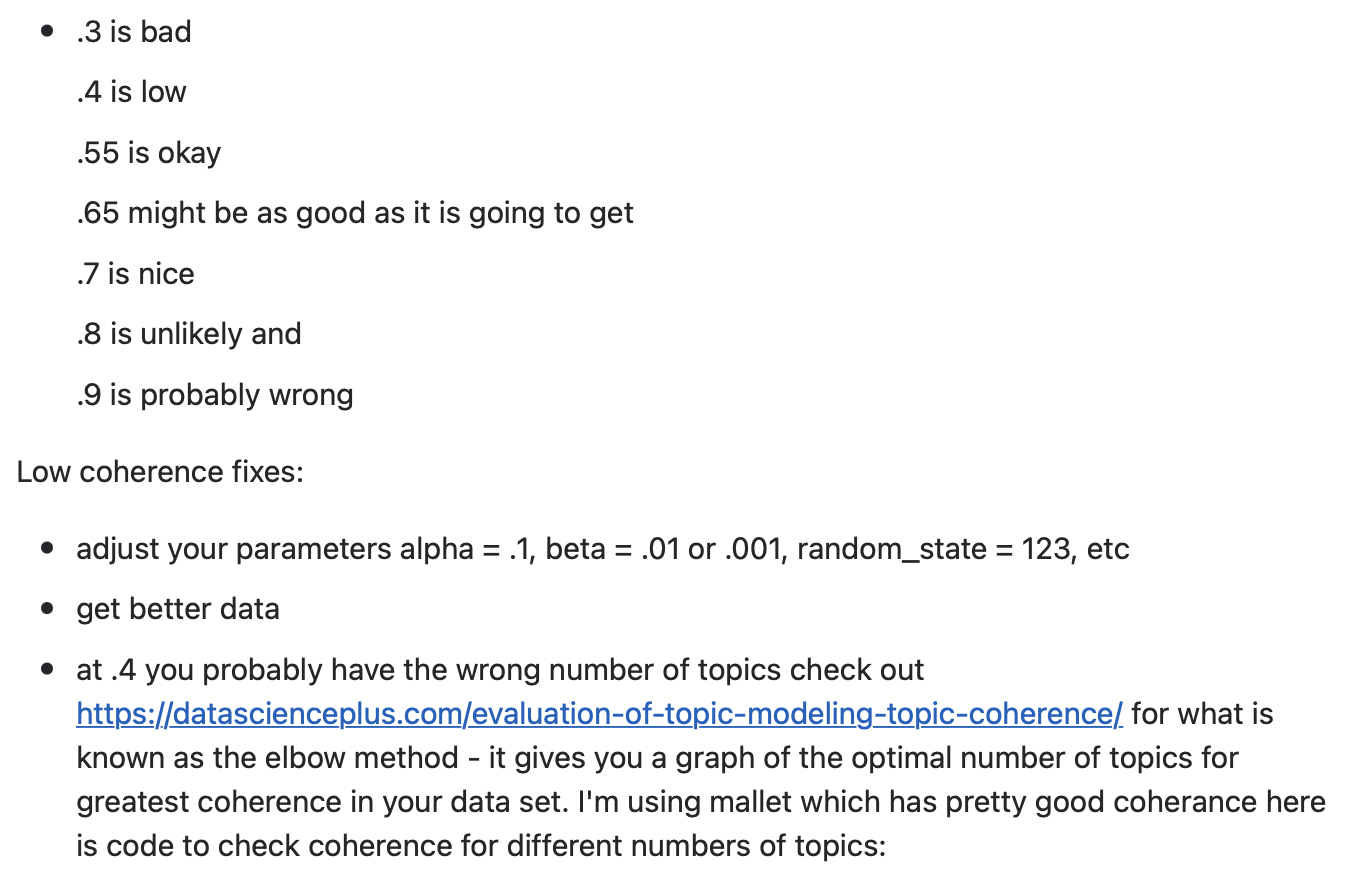

In [18]:
class MyLdaModel:
    def __init__(self, corpus, dictionary, filtered_docs, model=None, *args, **kwargs):
        self.corpus = corpus
        self.dictionary = dictionary
        self.filtered_docs = filtered_docs
        if model:
            self.model = model
        else:
            self.model = LdaMulticore(
                corpus=corpus,
                id2word=dictionary,
                *args, **kwargs)

    def print_words_distributions(self, k=10):
        for topic_id in range(self.model.num_topics):
            topk = self.model.show_topic(topic_id, k)
            topk_words = [ w for w, _ in topk ]

            print('{}: {}'.format(topic_id, ' '.join(topk_words)))

    def plot_word_cloud(self, topn=50):
        for topic in range(self.model.num_topics):
            topic_words_freq = dict(self.model.show_topic(topic, topn=topn))
            cloud = WordCloud(max_font_size=80, colormap="hsv").generate_from_frequencies(topic_words_freq)
            plt.figure(figsize=(16,12))
            plt.imshow(cloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'WordCloud topic: {topic}', size=20)
            plt.show()

    def calculate_metrics(self, is_log_perplexity=False):
        self.cm_cv = CoherenceModel(model=self.model, 
                                    texts=self.filtered_docs,
                                    corpus=self.corpus,
                                    coherence='c_v',
                                    dictionary=self.dictionary)
        
        self.cm_um = CoherenceModel(model=self.model, 
                                    texts=self.filtered_docs,
                                    corpus=self.corpus,
                                    coherence='u_mass',
                                    dictionary=self.dictionary)

        self.cm_w2v = CoherenceModel(model=self.model,
                                     texts=self.filtered_docs,
                                     corpus=self.corpus,
                                     coherence='c_w2v',
                                     dictionary=self.dictionary)
        if is_log_perplexity:
            print('the lower the perplexity, the better the model. Not a good metric.')
            print(f'Perplexity: {self.model.log_perplexity(self.corpus)}')
        with np.errstate(invalid='ignore'):
            print(f'Coherence Score cv: {self.cm_cv.get_coherence()}, 0.5 - 0.8 - good')
        print(f'Coherence Score um: {self.cm_um.get_coherence()}, should be between -14 and 14 or so, 0 - worst')
        print(f'Coherence Score w2v: {self.cm_w2v.get_coherence()}, the bigger the better')

    def coherence_per_topic(self):
        coherence_per_topic = (self.cm_cv.get_coherence_per_topic(),
                               self.cm_um.get_coherence_per_topic(),
                               self.cm_w2v.get_coherence_per_topic())
        topics_str = []
        for topic_id in range(self.model.num_topics):
            topk = self.model.show_topic(topic_id, 4)
            topk_words = [ w for w, _ in topk ]
            topics_str.append('\n '.join(topk_words))
        metrics = ['Coherence Score cv', 'Coherence Score um', 'Coherence Score w2v']
        data_topic_score = pd.DataFrame(data=zip(topics_str, coherence_per_topic[0], coherence_per_topic[1], coherence_per_topic[2]),
                                        columns=['Topic'] +  metrics)
        data_topic_score = data_topic_score.set_index('Topic')
        fig, axes = plt.subplots(1, len(metrics), figsize=(16, 12))
        for metric, ax in zip(metrics, axes):
            ax.set_title(metric)
            sns.heatmap(data=data_topic_score[metric].to_frame(), annot=True, square=True,
                        cmap='Reds', fmt='.2f',
                        linecolor='black', ax=ax )
            plt.yticks( rotation=0 )
            ax.set_xlabel('')
            ax.set_ylabel('')
        fig.show()

    def plot_LDAvis(self):
        LDAvis_prepared = pyLDAvis.gensim_models.prepare(self.model, self.corpus, self.dictionary)
        return LDAvis_prepared

    def predict(self, BoW):
        result = []
        for prediction in self.model.get_document_topics(BoW):
            result.append(max(prediction, key=lambda x: x[1]))
        return result

In [23]:
%%time
lda_model = MyLdaModel(corpus=BoW,
                       dictionary=BoW_model_title_abst.dictionary,
                       filtered_docs=BoW_model_title_abst._filtered_docs,
                       num_topics=10, 
                       random_state=123,
                       chunksize=100000,
                       passes=2,
                       per_word_topics=True
                      )

CPU times: user 4min 47s, sys: 30.9 s, total: 5min 18s
Wall time: 6min 2s


In [24]:
lda_model.print_words_distributions()

0: use base model system comput algorithm problem network paper result
1: use imag algorithm base result method perform system propos paper
2: base use method system comput set propos time queri problem
3: model system algorithm use base data paper propos design result
4: use system network base algorithm inform model time present user
5: model use network base data paper gener system propos comput
6: system use base time network paper control model propos data
7: problem method model algorithm use system result paper time base
8: system use inform servic paper applic data model develop process
9: use data model method base paper problem propos imag present


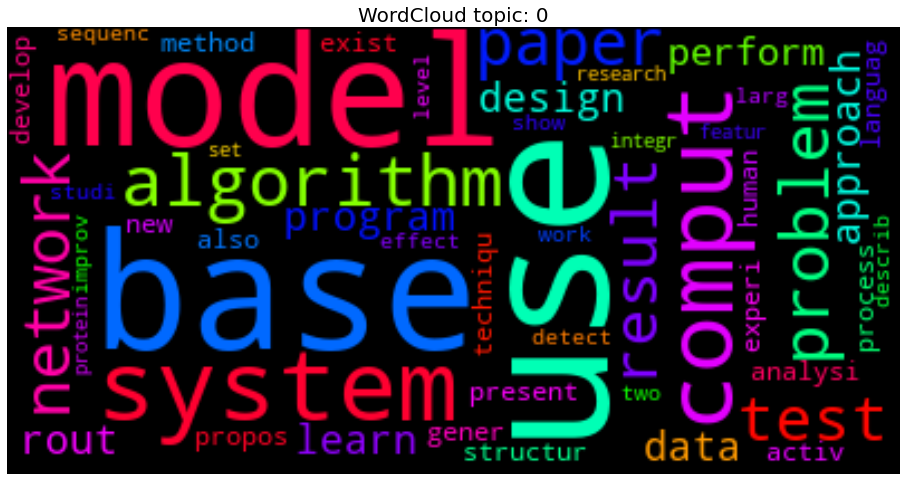

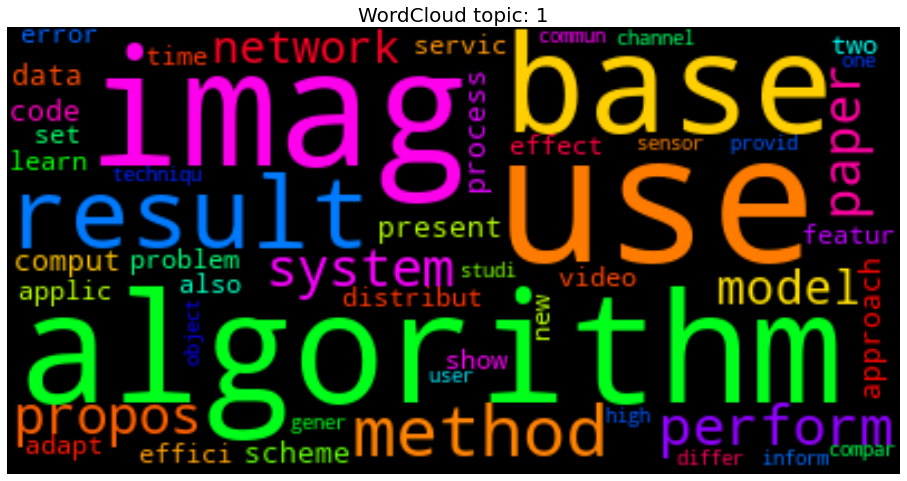

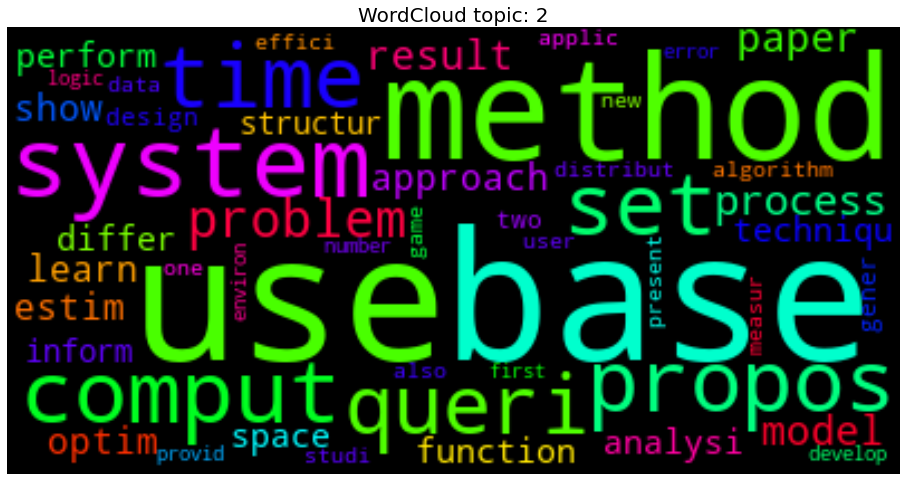

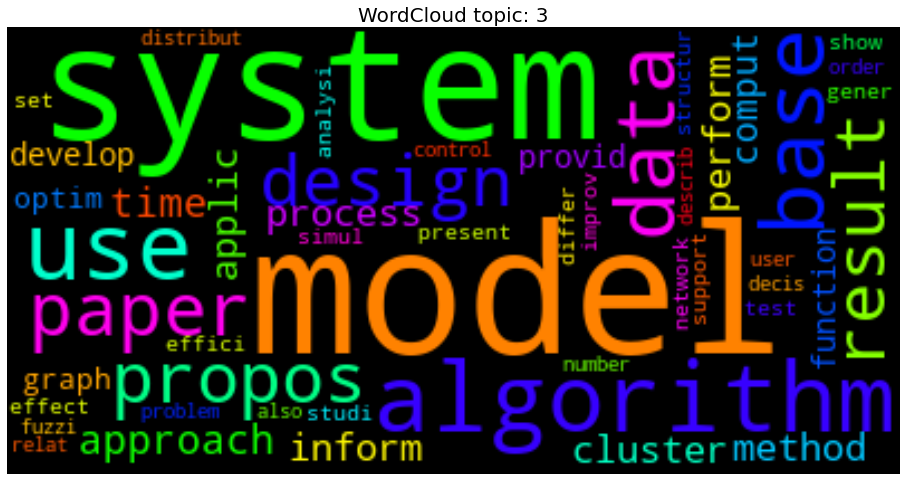

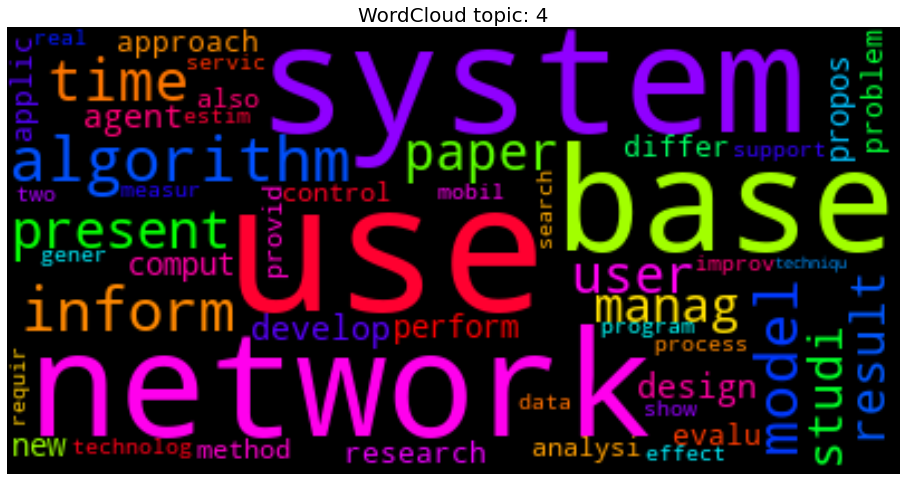

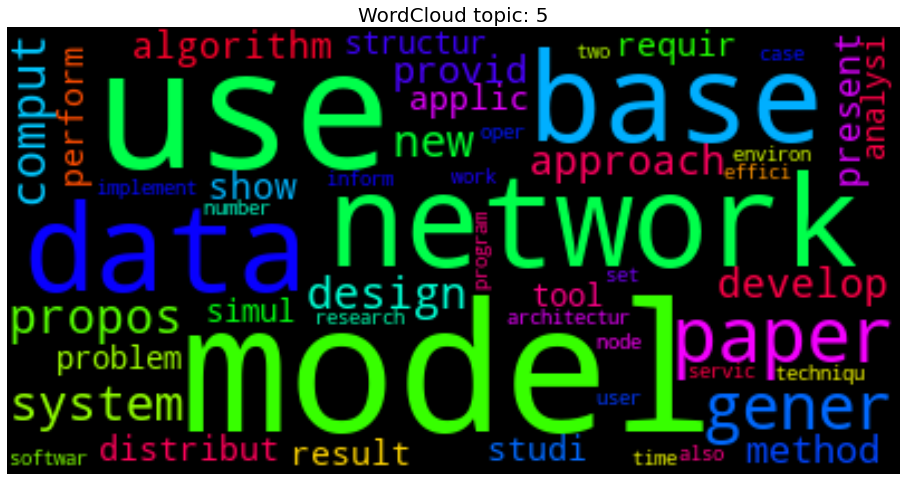

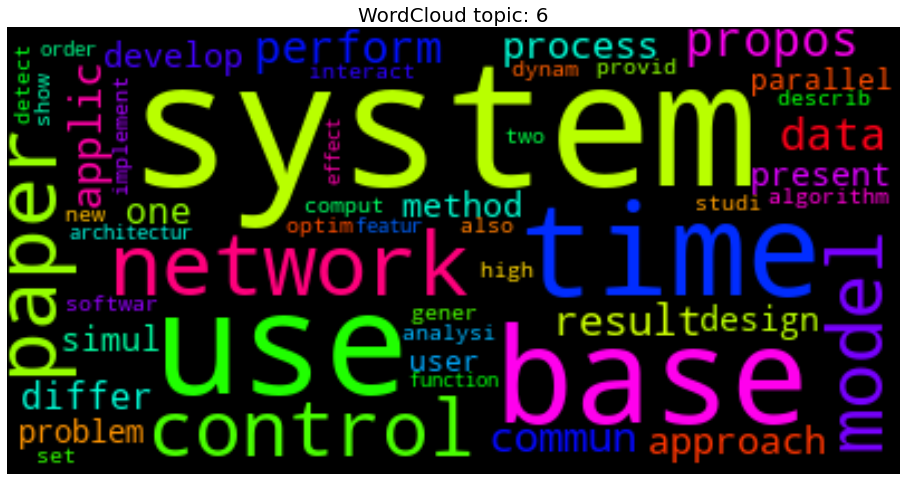

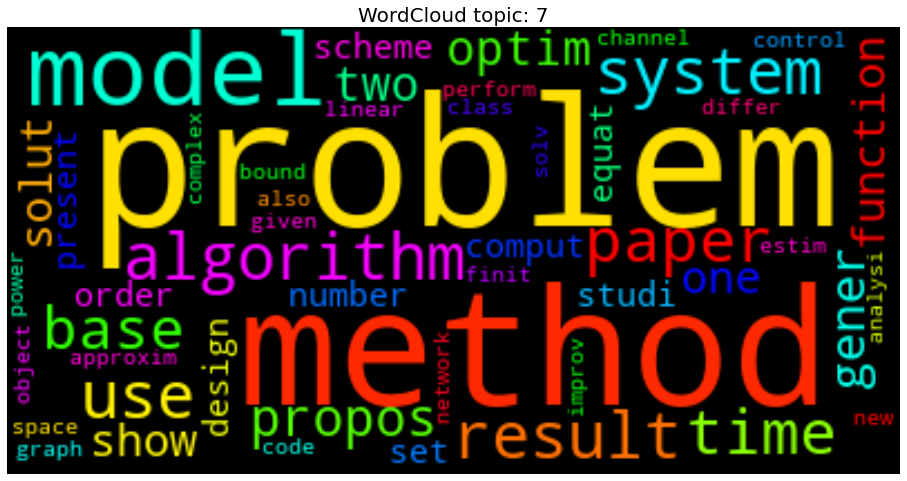

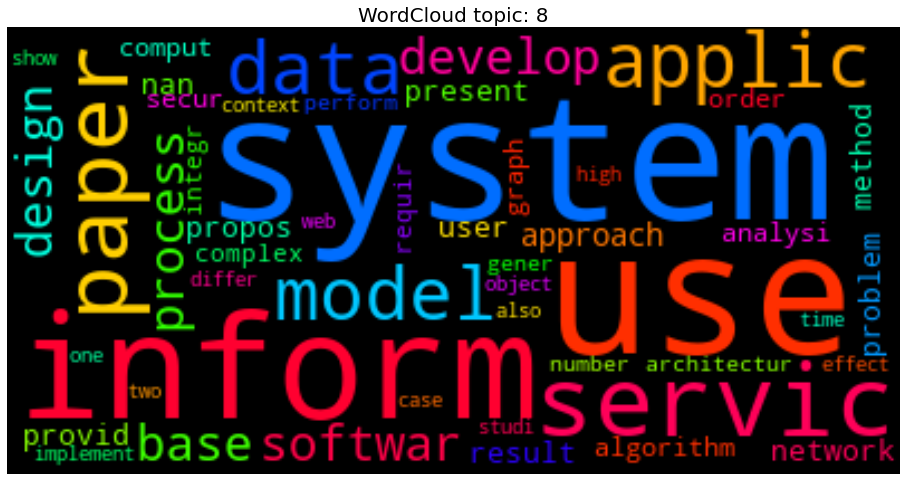

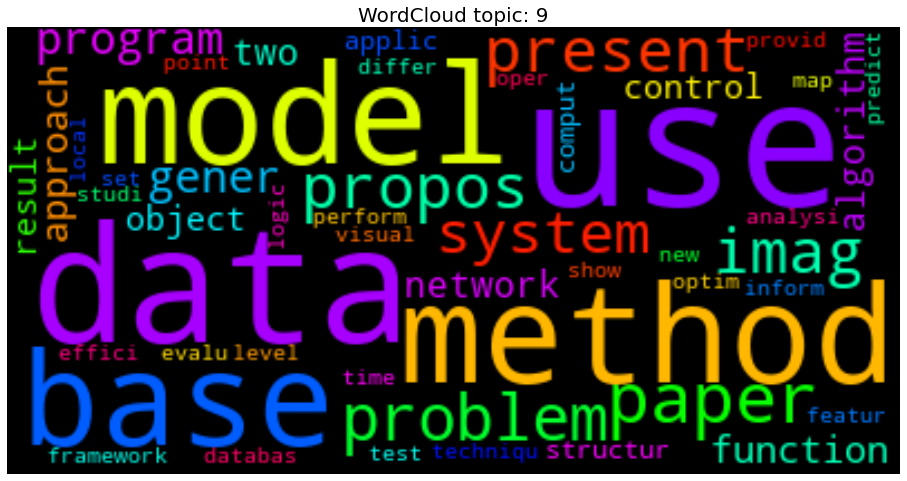

In [25]:
lda_model.plot_word_cloud()

In [26]:
%%time
lda_model.calculate_metrics(is_log_perplexity=True)

the lower the perplexity, the better the model. Not a good metric.
Perplexity: -8.978597211261448
Coherence Score cv: 0.3709006979220225, 0.5 - 0.8 - good
Coherence Score um: -1.6048568992466155, should be between -14 and 14 or so, 0 - worst
Coherence Score w2v: 0.757776141166687, the bigger the better
CPU times: user 58min 43s, sys: 23.4 s, total: 59min 6s
Wall time: 15min 23s


/var/folders/r_/bq4swdms3vj5wr80yf1vm4nh0000gn/T/ipykernel_43088/1748010280.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


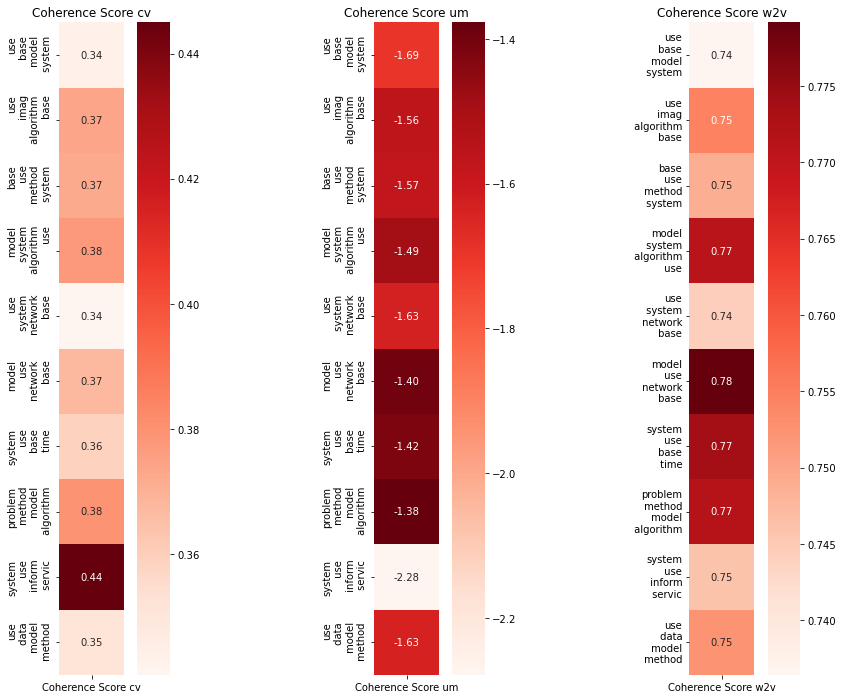

In [27]:
lda_model.coherence_per_topic()

In [28]:
lda_model.plot_LDAvis()

/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/U

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.075241  0.016497       1        1  15.158988
1     -0.014286  0.005411       2        1  12.251515
6      0.011575  0.014749       3        1  12.045402
9     -0.006805 -0.030332       4        1  11.199887
8      0.032077  0.019901       5        1  10.062573
4      0.027194  0.016869       6        1   9.527225
3      0.011918 -0.011290       7        1   7.875824
0      0.018845 -0.022506       8        1   7.491279
5      0.014535  0.006368       9        1   7.393508
2     -0.019814 -0.015667      10        1   6.993800, topic_info=        Term           Freq          Total Category  logprob  loglift
334    model  551986.000000  551986.000000  Default  30.0000  30.0000
37      imag  190380.000000  190380.000000  Default  29.0000  29.0000
553     data  368944.000000  368944.000000  Default  28.0000  28.0000
0        nan   38692.000000   38692.000000  Default  27.0000  27.0000
754   servic  143973.000000  143973.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
273      two   16105.042666  225794.970009  Topic10  -5.9896   0.0197
64   perform   17128.866204  294083.394350  Topic10  -5.9280  -0.1830
318   inform   16112.044523  248530.788202  Topic10  -5.9892  -0.0759
141   design   16110.331860  259421.719973  Topic10  -5.9893  -0.1188
424    gener   14674.861433  263526.948928  Topic10  -6.0826  -0.2279

[1009 rows x 6 columns], token_table=        Topic      Freq         Term
term                                
100734      3  0.094501  aaai spring
100734      5  0.094501  aaai spring
100734      6  0.094501  aaai spring
100734      8  0.094501  aaai spring
100734      9  0.567003  aaai spring
...       ...       ...          ...
3798        6  0.090345          zur
3798        7  0.157926          zur
3798        8  0.121290          zur
3798        9  0.085365          zur
3798       10  0.438920          zur

[7111 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 7, 10, 9, 5, 4, 1, 6, 3])

Each bubble on the left-hand side represents topic. The larger the bubble, the more prevalent or dominant the topic is. Good topic model will be fairly big topics scattered in different quadrants rather than being clustered on one quadrant.
The model with too many topics will have many overlaps, small sized bubbles clustered in one region of chart.

## LDAMallet

In [29]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2022-10-17 11:49:34--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu... 128.119.246.70
Connecting to mallet.cs.umass.edu|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-10-17 11:49:35--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: 'mallet-2.0.8.zip'

mallet-2.0.8.zip    100%[===================>]  15.43M  4.29MB/s    in 3.6s    

2022-10-17 11:49:39 (4.29 MB/s) - 'mallet-2.0.8.zip' saved [16184794/16184794]



In [30]:
# !unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

  inflating: mallet-2.0.8/class/cc/mallet/extract/PerDocumentF1Evaluator.class  
  inflating: mallet-2.0.8/class/cc/mallet/extract/PerFieldF1Evaluator.class  
   creating: mallet-2.0.8/class/cc/mallet/extract/pipe/
  inflating: mallet-2.0.8/class/cc/mallet/extract/pipe/TokenSequence2Tokenization.class  
  inflating: mallet-2.0.8/class/cc/mallet/extract/PunctuationIgnoringComparator.class  
  inflating: mallet-2.0.8/class/cc/mallet/extract/Record.class  
  inflating: mallet-2.0.8/class/cc/mallet/extract/RegexFieldCleaner.class  
  inflating: mallet-2.0.8/class/cc/mallet/extract/Span.class  
  inflating: mallet-2.0.8/class/cc/mallet/extract/StringSpan.class  
  inflating: mallet-2.0.8/class/cc/mallet/extract/StringTokenization.class  
   creating: mallet-2.0.8/class/cc/mallet/extract/test/
  inflating: mallet-2.0.8/class/cc/mallet/extract/test/TestDocumentExtraction.class  
  inflating: mallet-2.0.8/class/cc/mallet/extract/test/TestDocumentViewer.class  
  inflating: mallet-2.0.8/class/c

  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/Factors.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/HashVarSet.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/ListVarSet$Iterator.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/ListVarSet.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/LogTableFactor.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/NormalFactor.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/ParameterizedFactor.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/PottsTableFactor.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/SkeletonFactor.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/SparseAssignmentIterator.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/TableFactor.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/Tree.class  
  inflating: mallet-2.0.8/class/cc/mallet/grmm/types/UndirectedGrid.class  
  inflating: mallet-

  inflating: mallet-2.0.8/class/cc/mallet/types/NullLabel.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/PagedInstanceList.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/PartiallyRankedFeatureVector$Factory.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/PartiallyRankedFeatureVector$PerLabelFactory.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/PartiallyRankedFeatureVector.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/PerLabelFeatureCounts$Factory.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/PerLabelFeatureCounts.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/PerLabelInfoGain$Factory.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/PerLabelInfoGain.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/PropertyHolder.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/RankedFeatureVector$EntryWithOriginalIndex.class  
  inflating: mallet-2.0.8/class/cc/mallet/types/RankedFeatureVector$Factory.class  
  inflati

  inflating: mallet-2.0.8/dist/mallet.jar  
   creating: mallet-2.0.8/lib/
  inflating: mallet-2.0.8/lib/bsh.jar  
  inflating: mallet-2.0.8/lib/derby.jar  
  inflating: mallet-2.0.8/lib/grmm-deps.jar  
  inflating: mallet-2.0.8/lib/jdom-1.0.jar  
  inflating: mallet-2.0.8/lib/jgrapht-0.6.0.jar  
  inflating: mallet-2.0.8/lib/junit-4.5.jar  
  inflating: mallet-2.0.8/lib/jwnl-1.3.jar  
  inflating: mallet-2.0.8/lib/LICENSES  
  inflating: mallet-2.0.8/lib/Makefile  
  inflating: mallet-2.0.8/lib/mallet-deps.jar  
  inflating: mallet-2.0.8/lib/mtj-0.9.9.jar  
  inflating: mallet-2.0.8/lib/openjgraph.jar  
  inflating: mallet-2.0.8/lib/trove-2.0.2.jar  
  inflating: mallet-2.0.8/LICENSE    
  inflating: mallet-2.0.8/Makefile   
  inflating: mallet-2.0.8/pom.xml    
  inflating: mallet-2.0.8/README.md  
   creating: mallet-2.0.8/sample-data/
   creating: mallet-2.0.8/sample-data/numeric/
  inflating: mallet-2.0.8/sample-data/numeric/boxes.txt  
  inflating: mallet-2.0.8/sample-data/numeri

  inflating: mallet-2.0.8/src/cc/mallet/fst/semi_supervised/constraints/OneLabelL2RangeGEConstraints.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/semi_supervised/constraints/SelfTransitionGEConstraint.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/semi_supervised/constraints/TwoLabelGEConstraints.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/semi_supervised/constraints/TwoLabelKLGEConstraints.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/semi_supervised/constraints/TwoLabelL2GEConstraints.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/semi_supervised/CRFOptimizableByEntropyRegularization.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/semi_supervised/CRFOptimizableByGE.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/semi_supervised/CRFTrainerByEntropyRegularization.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/semi_supervised/CRFTrainerByGE.java  
  inflating: mallet-2.0.8/src/cc/mallet/fst/semi_supervised/CRFTrainerByLikelihoodAndGE.java  
  inflatin

   creating: mallet-2.0.8/src/cc/mallet/grmm/learning/templates/
  inflating: mallet-2.0.8/src/cc/mallet/grmm/learning/templates/SimilarTokensTemplate.java  
   creating: mallet-2.0.8/src/cc/mallet/grmm/test/
  inflating: mallet-2.0.8/src/cc/mallet/grmm/test/TestAbstractBeliefPropagation.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/test/TestAssignment.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/test/TestAssignmentIterator.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/test/TestBetaFactor.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/test/TestBitVarSet.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/test/TestDirectedModel.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/test/TestFactorGraph.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/test/TestFactors.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/test/TestGenericAcrfData2TokenSequence.java  
  inflating: mallet-2.0.8/src/cc/mallet/grmm/test/TestGibbsSampler.java  
  inflating: mallet-2.0.8/s

  inflating: mallet-2.0.8/src/cc/mallet/util/ArrayUtils.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/BshInterpreter.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/BulkLoader.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/CharSequenceLexer.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/CollectionUtils.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/ColorUtils.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/CommandOption.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/DBBulkLoader.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/DBInstanceStore.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/DirectoryFilter.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/DocumentLengths.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/DoubleList.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/FeatureCooccurrenceCounter.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/FeatureCountTool.java  
  inflating: mallet-2.0.8/src/cc/mallet/util/FileUtils.java 

In [19]:
mallet_path = './mallet-2.0.8/bin/mallet'

In [ ]:
%%time
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=BoW, num_topics=10, id2word=BoW_model_title_abst.dictionary, workers=5)

In [ ]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, corpus=BoW, dictionary=BoW_model_title_abst.dictionary,
                                           texts=BoW_model_title_abst._filtered_docs, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score cv: ', coherence_ldamallet)

In [ ]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, corpus=BoW, dictionary=BoW_model_title_abst.dictionary,
                                           texts=BoW_model_title_abst._filtered_docs, coherence='u_mass')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score um: ', coherence_ldamallet)

# Model Selection

In [71]:
def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=2, end_topic_count=10, step=1):
    coherence_scores = []
    nums_topics = list(range(start_topic_count, end_topic_count+1, step))
    for topic_nums in tqdm_notebook(nums_topics):
        lda_model = LdaMulticore(corpus=corpus, num_topics=topic_nums, id2word=dictionary, random_state=123,
                                chunksize=100000, passes=2, per_word_topics=True)

        cv_coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, texts=texts,
                                                       dictionary=dictionary, coherence='c_v')

        coherence_scores.append(cv_coherence_model_lda.get_coherence())
    return coherence_scores, nums_topics

In [72]:
coherence_scores, nums_topics = topic_model_coherence_generator(corpus=BoW, texts=BoW_model_title_abst._filtered_docs,
                                                                dictionary=BoW_model_title_abst.dictionary,
                                                                start_topic_count=2, end_topic_count=50, step=2)

  0%|          | 0/25 [00:00<?, ?it/s]

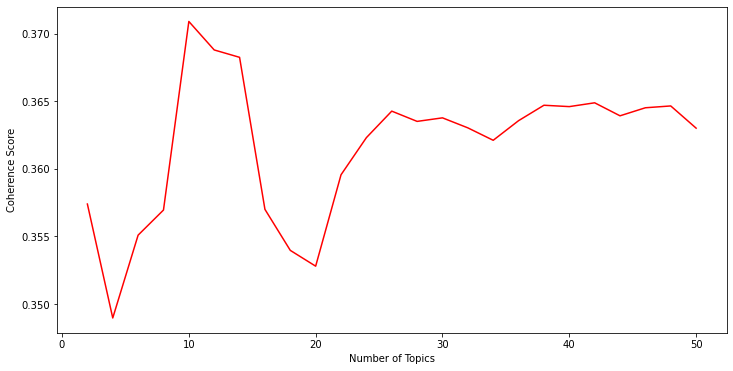

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(nums_topics, coherence_scores, c='r')
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [76]:
coherence_scores_75_100 = []
nums_topics_75_100 = [75, 100]
for topic_nums in tqdm_notebook(nums_topics_75_100):
    lda_model = LdaMulticore(corpus=BoW, num_topics=topic_nums, id2word=BoW_model_title_abst.dictionary, random_state=123,
                            chunksize=100000, passes=2, per_word_topics=True)

    cv_coherence_model_lda = CoherenceModel(model=lda_model, corpus=BoW, texts=BoW_model_title_abst._filtered_docs,
                                                   dictionary=BoW_model_title_abst.dictionary, coherence='c_v')

    coherence_scores_75_100.append(cv_coherence_model_lda.get_coherence())

  0%|          | 0/2 [00:00<?, ?it/s]

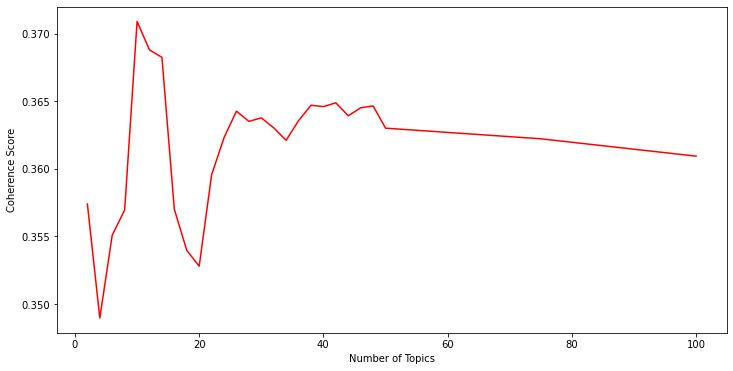

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(nums_topics + nums_topics_75_100, coherence_scores + coherence_scores_75_100, c='r')
plt.rcParams['figure.facecolor'] = 'white'
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [20]:
%%time
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=BoW, num_topics=42, id2word=BoW_model_title_abst.dictionary, workers=5)

Mallet LDA: 42 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 20595
total tokens: 110874648
<10> LL/token: -10,52385
<20> LL/token: -9,11154
<30> LL/token: -8,06267
<40> LL/token: -7,63619

0	1,19048	result high improv show order perform effect compar size small experiment techniqu reduc compress higher increas significantli stage rang signific 
1	1,19048	languag queri semant search document retriev text word base inform ontolog similar index context relat natur term translat automat relev 
2	1,19048	logic type rule properti relat defin reason theori formal order concept proof set introduc definit express infer algebra notion extend 
3	1,19048	research technolog discuss issu year scienc futur articl digit review recent area challeng electron practic author work current survey paper 
4	1,19048	servic web mobil user provid access devic base internet content server support context locat awar environ multimedia enabl page architectur 
5	1,19048	graph number class prove ed

<100> LL/token: -7,21133
<110> LL/token: -7,19469
<120> LL/token: -7,18278
<130> LL/token: -7,17386
<140> LL/token: -7,16538

0	1,19048	perform improv high result show reduc order compar increas achiev effect significantli signific cost reduct higher low techniqu experiment speed 
1	1,19048	queri semant search document retriev languag text similar word index ontolog term automat context knowledg rank relev relat natur answer 
2	1,19048	type logic theori rule relat properti formal order defin reason concept express introduc algebra proof definit notion term extend prove 
3	1,19048	research technolog discuss issu year scienc articl digit area futur challeng recent review author current paper survey advanc emerg librari 
4	1,19048	servic web mobil provid access devic internet support environ server locat content awar context platform enabl architectur page paper technolog 
5	1,19048	graph class number polynomi edg show prove connect complet free degre give result everi vertic finit famili

<200> LL/token: -7,14627
<210> LL/token: -7,14477
<220> LL/token: -7,14298
<230> LL/token: -7,14014
<240> LL/token: -7,13833

0	1,19048	perform improv high result reduc show compar achiev order cost increas significantli effect signific low reduct techniqu speed higher effici 
1	1,19048	queri semant search document retriev languag text similar word index ontolog term automat knowledg context rank relat relev natur answer 
2	1,19048	type logic theori rule relat properti order reason defin concept express algebra introduc proof definit formal notion term extend prove 
3	1,19048	research technolog discuss issu year articl scienc area futur challeng digit review recent author current commun paper survey advanc emerg 
4	1,19048	servic web mobil provid access devic internet support environ server locat awar context platform content enabl architectur paper page technolog 
5	1,19048	graph class number polynomi edg show prove connect complet degre free give result everi vertic exist finit regul

<300> LL/token: -7,12803
<310> LL/token: -7,12631
<320> LL/token: -7,12475
<330> LL/token: -7,12335
<340> LL/token: -7,12225

0	1,19048	perform improv high reduc result show achiev compar cost order increas significantli low signific reduct effici effect speed higher enhanc 
1	1,19048	queri semant document retriev search languag text word similar knowledg index ontolog automat term context rank relat relev natur answer 
2	1,19048	type logic theori rule relat properti order reason defin concept algebra introduc definit proof express formal notion term show complet 
3	1,19048	research technolog discuss issu year articl area scienc futur challeng digit review author current paper recent commun advanc survey emerg 
4	1,19048	servic web mobil provid access devic internet support environ server awar locat context platform content enabl architectur paper page avail 
5	1,19048	graph class number polynomi edg show prove connect free complet degre give result everi vertic famili regular exist di

<400> LL/token: -7,11421
<410> LL/token: -7,1141
<420> LL/token: -7,11377
<430> LL/token: -7,1135
<440> LL/token: -7,11336

0	1,19048	perform improv high reduc result show achiev compar cost order increas significantli low signific reduct effici speed effect higher enhanc 
1	1,19048	queri semant search document retriev languag text similar word index ontolog automat term context rank relat relev natur answer annot 
2	1,19048	type logic theori rule relat properti order reason defin concept algebra definit proof introduc express formal notion term complet extend 
3	1,19048	research technolog discuss issu year articl area scienc futur challeng digit review author current paper recent commun advanc survey emerg 
4	1,19048	servic web mobil provid access devic internet support environ server awar locat context platform architectur enabl content paper page avail 
5	1,19048	graph number class polynomi edg show connect prove complet free degre give result everi vertic regular famili exist direc

<500> LL/token: -7,11207
<510> LL/token: -7,11166
<520> LL/token: -7,11151
<530> LL/token: -7,11116
<540> LL/token: -7,11092

0	1,19048	perform improv high reduc result show achiev compar cost order increas significantli low signific effici reduct speed effect higher enhanc 
1	1,19048	queri semant document retriev search languag text similar word index ontolog automat term context rank relat relev natur answer translat 
2	1,19048	type logic theori rule relat properti order reason defin concept algebra introduc proof definit express notion formal term show prove 
3	1,19048	research technolog discuss issu year articl area futur challeng scienc digit review author current recent paper commun advanc survey emerg 
4	1,19048	servic web mobil provid access devic internet support environ server awar locat context platform content architectur enabl paper technolog page 
5	1,19048	graph number class polynomi edg show connect prove complet free degre give result everi vertic regular famili exist 

<600> LL/token: -7,11064
<610> LL/token: -7,1107
<620> LL/token: -7,11082
<630> LL/token: -7,11089
<640> LL/token: -7,1111

0	1,19048	perform improv high reduc result show achiev compar cost order increas low significantli signific effici reduct speed effect higher enhanc 
1	1,19048	queri semant document retriev search languag text similar word index ontolog term automat relat rank context relev natur answer translat 
2	1,19048	type logic theori rule relat properti order reason defin concept algebra proof introduc express definit notion formal term show complet 
3	1,19048	research technolog discuss issu year articl area futur scienc challeng digit review author paper current recent commun advanc survey emerg 
4	1,19048	servic web mobil provid access devic internet support server environ awar context locat platform architectur content enabl paper avail page 
5	1,19048	graph number class polynomi show edg prove connect complet degre free give result everi vertic regular direct famili exi

<700> LL/token: -7,11045
<710> LL/token: -7,11013
<720> LL/token: -7,10998
<730> LL/token: -7,11003
<740> LL/token: -7,10992

0	1,19048	perform improv high reduc result show achiev compar cost order increas low significantli signific effici reduct speed effect higher enhanc 
1	1,19048	queri semant document retriev search languag text similar word index ontolog automat term relat rank context relev natur answer translat 
2	1,19048	type logic theori rule properti relat order reason defin concept algebra proof introduc definit notion express show formal prove complet 
3	1,19048	research technolog discuss issu year articl area futur scienc challeng digit review author paper current recent commun advanc address survey 
4	1,19048	servic web mobil provid access devic internet support environ server awar context locat architectur platform content enabl paper avail page 
5	1,19048	graph number polynomi class show edg connect prove give degre free complet result everi vertic regular famili direc

<800> LL/token: -7,10962
<810> LL/token: -7,10973
<820> LL/token: -7,10985
<830> LL/token: -7,10952
<840> LL/token: -7,10951

0	1,19048	perform improv high reduc result show achiev compar cost order increas low significantli signific reduct effici speed effect higher enhanc 
1	1,19048	queri semant document retriev search languag text similar word index ontolog automat term rank relat context relev natur answer translat 
2	1,19048	type logic theori rule properti relat order reason defin concept algebra proof introduc class notion definit express show formal complet 
3	1,19048	research technolog discuss issu year articl area futur scienc challeng digit review author paper current recent commun advanc survey emerg 
4	1,19048	servic web mobil provid access devic internet support environ server locat awar context platform architectur enabl content paper avail page 
5	1,19048	graph number polynomi show edg connect prove give free degre complet class result everi vertic direct famili regular 

<900> LL/token: -7,10959
<910> LL/token: -7,1095
<920> LL/token: -7,10968
<930> LL/token: -7,10972
<940> LL/token: -7,10967

0	1,19048	perform improv high reduc result show achiev compar cost order increas low significantli signific reduct effici speed effect higher enhanc 
1	1,19048	queri semant document retriev languag search text word similar index ontolog automat term rank context relat relev natur answer translat 
2	1,19048	type logic theori rule relat properti order reason defin concept algebra proof class introduc notion definit express show prove complet 
3	1,19048	research technolog discuss issu year articl challeng futur scienc area digit review author paper current recent commun advanc survey emerg 
4	1,19048	servic web mobil provid access devic internet support environ server locat awar context architectur platform enabl content paper avail page 
5	1,19048	graph number polynomi show edg connect prove give free degre complet class result everi vertic direct regular famili ex

<1000> LL/token: -7,10985

Total time: 40 minutes 49 seconds


CPU times: user 3min 47s, sys: 7.93 s, total: 3min 55s
Wall time: 47min 55s


In [21]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, corpus=BoW, dictionary=BoW_model_title_abst.dictionary,
                                           texts=BoW_model_title_abst._filtered_docs, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score cv: ', coherence_ldamallet)

Coherence Score cv:  0.49412474541573803


In [22]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [23]:
coherence_model_ldamallet = CoherenceModel(model=model, corpus=BoW, dictionary=BoW_model_title_abst.dictionary,
                                           texts=BoW_model_title_abst._filtered_docs, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score cv: ', coherence_ldamallet)

Coherence Score cv:  0.49412474541573803


In [24]:
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, BoW, BoW_model_title_abst.dictionary)
LDAvis_prepared

/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/U

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.147890  0.132403       1        1  2.915651
19     0.019702  0.017132       2        1  2.765222
39    -0.134864  0.035536       3        1  2.693249
37    -0.121924  0.024243       4        1  2.652713
6     -0.088141  0.148574       5        1  2.629473
33     0.104407 -0.026102       6        1  2.624706
2     -0.104114 -0.137033       7        1  2.624473
38     0.067969  0.014079       8        1  2.597484
32     0.134835  0.087600       9        1  2.567200
30    -0.033070  0.140987      10        1  2.565806
41     0.162548  0.166146      11        1  2.561605
17     0.084945  0.255090      12        1  2.559160
26    -0.197403 -0.096182      13        1  2.542748
1      0.020127  0.000332      14        1  2.532994
5     -0.205936 -0.076338      15        1  2.500995
4      0.230840  0.018569      16        1  2.484683
20    -0.192931  0.039703      17        1  2.483085
13    -0.087953  0.198215      18        1  2.466221
0     -0.133470  0.087742      19        1  2.464812
16     0.048977  0.004748      20        1  2.388529
12     0.194672  0.030841      21        1  2.386195
8     -0.095721 -0.042137      22        1  2.383802
25     0.042721 -0.058302      23        1  2.374301
21    -0.028203  0.007266      24        1  2.364097
35     0.118656 -0.139434      25        1  2.346172
27    -0.088558  0.053738      26        1  2.343821
18    -0.208173 -0.043800      27        1  2.307339
23     0.000435 -0.027909      28        1  2.272203
9     -0.097048  0.182923      29        1  2.264753
22    -0.042522  0.010340      30        1  2.236786
7     -0.091878 -0.057400      31        1  2.202140
24    -0.096045  0.006776      32        1  2.185300
11     0.099366  0.015327      33        1  2.169920
40    -0.037277 -0.190527      34        1  2.134934
31     0.021105 -0.114005      35        1  2.127706
14     0.111138 -0.048292      36        1  2.118145
15     0.113657 -0.056518      37        1  2.088272
29    -0.005611 -0.138341      38        1  2.066370
28     0.153173 -0.145184      39        1  2.045097
36     0.064112 -0.140551      40        1  2.034024
10     0.126854 -0.116875      41        1  2.012456
34     0.022713 -0.023380      42        1  1.915356, topic_info=           Term          Freq         Total Category  logprob  loglift
358      system  1.230815e+06  1.230815e+06  Default  30.0000  30.0000
334       model  1.102854e+06  1.102854e+06  Default  29.0000  29.0000
112        base  9.502840e+05  9.502840e+05  Default  28.0000  28.0000
280   algorithm  8.048420e+05  8.048420e+05  Default  27.0000  27.0000
553        data  7.907490e+05  7.907490e+05  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
3132  introduct  7.702633e+03  1.496029e+04  Topic42  -5.4320   3.2914
60        paper  2.339567e+04  9.324564e+05  Topic42  -4.3210   0.2700
1662      refer  9.304426e+03  4.817216e+04  Topic42  -5.2431   2.3110
3321    version  8.314264e+03  3.884825e+04  Topic42  -5.3556   2.4136
4526    univers  7.466438e+03  3.596102e+04  Topic42  -5.4632   2.3832

[2845 rows x 6 columns], token_table=        Topic      Freq  Term
term                         
27791      16  1.000450   aaa
102239     25  0.005463  aadl
102239     40  0.994258  aadl
32356      31  0.998691   abc
32356      41  0.001311   abc
...       ...       ...   ...
2421        5  0.934897  zone
2421       23  0.000420  zone
2421       29  0.017013  zone
3798       42  0.999899   zur
4658       24  1.000472    µm

[7995 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 20, 40, 38, 7, 34, 3, 39, 33, 31, 42, 18, 27, 2, 6, 5, 21, 14, 1, 17, 13, 9, 26, 22, 36, 28, 19, 24, 10, 23, 8, 25, 12, 41, 32, 15, 16, 30, 29, 37, 11, 35])

In [27]:
lda_model = MyLdaModel(corpus=BoW, dictionary=BoW_model_title_abst.dictionary,
                       filtered_docs=BoW_model_title_abst._filtered_docs, model=model)

In [28]:
lda_model.print_words_distributions()

0: differ number larg scale size limit small wide rang mani
1: order oper power circuit reduct design current present paper mode
2: multipl channel signal frequenc nois fault phase receiv de interfer
3: estim distribut adapt paramet random sampl probabl statist markov stochast
4: data databas queri mine collect storag file integr relat xml
5: function class properti theori valu prove defin construct finit show
6: predict sequenc express structur gene protein cell avail biolog identifi
7: design develop softwar tool product engin requir support project methodolog
8: network mobil node commun sensor wireless neural locat connect topolog
9: make agent decis strategi behavior game role action play paper
10: studi effect measur result investig experi factor indic assess find
11: program languag logic semant specif type formal abstract descript reason
12: inform web search content retriev document digit relev rank index
13: activ field spatial tempor medic patient health region brain area
14

In [29]:
lda_model.calculate_metrics()

Coherence Score cv: 0.9994043988633032, 0.5 - 0.8 - good
Coherence Score um: -2.7081703718642207, should be between -14 and 14 or so, 0 - worst
Coherence Score w2v: nan, the bigger the better


/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dmitriimaksimov/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Production Model

In [25]:
class Model:
    def __init__(self, model, dictionary):
        self.model = model
        self.dictionary = dictionary
        self.stop_word = set(nltk.corpus.stopwords.words('english'))
        self.ps = nltk.stem.PorterStemmer()

    def _get_BoW_corpus(self, X):
        BoW_corpus = []
        for doc in self._docs_to_words(X):
            filtered_doc = [self._stemme(token) for token in doc if self._check(token)]
            BoW_corpus.append(self.dictionary.doc2bow(self._ngrams(filtered_doc), allow_update=False))
        return BoW_corpus

    @staticmethod
    def _docs_to_words(docs):
        for doc in docs:
            yield(simple_preprocess(str(doc), deacc=True))

    def _stemme(self, token):
        return self.ps.stem(token)
    
    def _check(self, token):
        return token not in self.stop_word

    def _ngrams(self, tokens):
        return (' '.join(a) for a in everygrams(tokens, max_len=2))

    def predict(self, X):
        BoW = self._get_BoW_corpus(X)
        result = []
        for prediction in self.model.get_document_topics(BoW):
            result.append(max(prediction, key=lambda x: x[1]))
        return result

In [27]:
prod_model = Model(model=model, dictionary=BoW_model_title_abst.dictionary)

In [28]:
import pickle
with open('model', 'wb') as picklefile:
    pickle.dump(prod_model, picklefile)

In [29]:
prod_model.predict(['I am AI developer', 'MAchine learning PCA MDS'])

[(12, 0.04212452150082872), (27, 0.06481010166674357)]

In [31]:
coherence_model_ldamallet = CoherenceModel(model=prod_model.model, corpus=BoW, dictionary=prod_model.dictionary,
                                           texts=BoW_model_title_abst._filtered_docs, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score cv: ', coherence_ldamallet)

Coherence Score cv:  0.49412474541573803


In [32]:
coherence_model_ldamallet = CoherenceModel(model=prod_model.model, corpus=BoW, dictionary=prod_model.dictionary,
                                           texts=BoW_model_title_abst._filtered_docs, coherence='c_w2v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score cv: ', coherence_ldamallet)

Coherence Score cv:  0.7331611


# Model investigation

In [33]:
results = model.get_document_topics(BoW)

In [45]:
df_en['tag'] = [max(i, key=lambda x: x[1])[0] for i in results]

/var/folders/r_/bq4swdms3vj5wr80yf1vm4nh0000gn/T/ipykernel_55884/1265146110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['tag'] = [max(i, key=lambda x: x[1])[0] for i in results]


In [46]:
df_en.head()

_id  \
0  53e99784b7602d9701f3e3f5   
1  53e99784b7602d9701f3e133   
2  53e99784b7602d9701f3e151   
3  53e99784b7602d9701f3e15d   
4  53e99784b7602d9701f3e161   

                                               title  \
0                                              3GIO.   
1  The relationship between canopy parameters and...   
2  A solution to the problem of touching and brok...   
3  Timing yield estimation using statistical stat...   
4                                               360°   

                                               venue    year  \
0                                        {'type': 0}  2011.0   
1  {'_id': '53a7297d20f7420be8bd4ae7', 'name_d': ...  2011.0   
2  {'_id': '53a72a4920f7420be8bfa51b', 'name_d': ...  1993.0   
3  {'_id': '53a72e2020f7420be8c80142', 'name_d': ...  2005.0   
4  {'_id': '5390a74a20f70186a0e8b40b', 'raw': 'AC...  2009.0   

                                            keywords  n_citation lang  \
0                                                 []         0.0   en   
1  [canopy parameters, canopy spectrum, different...         0.0   en   
2  [handwriting recognition, prototypes, image se...        17.0   en   
3  [sequential circuits, statistical distribution...        28.0   en   
4  [global high technology, daily short-distance ...         NaN   en   

                                             authors  \
0                                                NaN   
1  [{'_id': '53f45728dabfaec09f209538', 'name': '...   
2  [{'_id': '53f46797dabfaeb22f542630', 'name': '...   
3  [{'_id': '53f43b03dabfaedce555bf2a', 'name': '...   
4  [{'_id': '53f46946dabfaec09f24b4ed', 'name': '...   

                                                 fos page_start  ... issn  \
0                                                NaN        NaN  ...  NaN   
1  [Agronomy, Moisture, Hydrology, Environmental ...       1930  ...        
2  [Intelligent character recognition, Pattern re...        602  ...        
3  [Delay calculation, Timing failure, Monte Carl...       2461  ...        
4                                                NaN         39  ...        

            isbn                          doi  \
0            NaN                          NaN   
1                 10.1109/IGARSS.2011.6049503   
2                   10.1109/ICDAR.1993.395663   
3  0-7803-8834-8   10.1109/ISCAS.2005.1465124   
4                     10.1145/1665137.1665166   

                                                 pdf  \
0                                                NaN   
1                                               None   
2                                               None   
3  //static.aminer.org/pdf/PDF/000/423/329/timing...   
4                                                NaN   

                                                 url  \
0                                                NaN   
1    [http://dx.doi.org/10.1109/IGARSS.2011.6049503]   
2      [http://dx.doi.org/10.1109/ICDAR.1993.395663]   
3  [http://dx.doi.org/10.1109/ISCAS.2005.1465124,...   
4                                                NaN   

                                            abstract  \
0                                                NaN   
1  Drought is the first place in all the natural ...   
2                                                      
3  As process variations become a significant pro...   
4  360° represents the concerns that are addresse...   

                                          references chunk_idx  \
0                                                NaN         0   
1                                                NaN         0   
2  [53e99cf5b7602d97025ace63, 557e8a7a6fee0fe990c...         0   
3  [53e9a8a9b7602d97031f6bb9, 599c7b6b601a182cd27...         0   
4                                                NaN         0   

                                          title_abst tag  
0                                                NaN  34  
1  The relationship between canopy parameters and...   

In [48]:
from collections import defaultdict


for clust in tqdm_notebook(range(42)):
    temp_df = df_en[df_en.tag.eq(clust)]
    keywords = defaultdict(int)
    fos = defaultdict(int)
    for row in temp_df[['keywords', 'fos']].itertuples():
        if not isinstance(row.keywords, list):
            keywords['nothing'] += 1
        else:
            for key in row.keywords:
                keywords[key] += 1
        if not isinstance(row.fos, list):
            fos['nothing'] += 1
        else:
            for key in row.fos:
                fos[key] += 1
    print(f'cluster: {clust}')
    print("Статистика по top keywords:")
    for key in sorted(keywords.keys(), key=lambda x: keywords[x], reverse=True)[:10]:
        print(f'{key} встречался {keywords[key]} раз')
    print('-' * 100)
    print("Статистика по top fos:")
    for key in sorted(fos.keys(), key=lambda x: fos[x], reverse=True)[:10]:
        print(f'{key} встречался {fos[key]} раз')
    print('#' * 100)

  0%|          | 0/42 [00:00<?, ?it/s]

cluster: 0
Статистика по top keywords:
data mining встречался 92 раз
system performance встречался 91 раз
computational complexity встречался 83 раз
computer science встречался 78 раз
computer architecture встречался 77 раз
performance evaluation встречался 72 раз
algorithm design and analysis встречался 70 раз
hardware встречался 69 раз
real time встречался 68 раз
performance встречался 67 раз
----------------------------------------------------------------------------------------------------
Статистика по top fos:
Computer science встречался 2785 раз
nothing встречался 1450 раз
Artificial intelligence встречался 529 раз
Algorithm встречался 498 раз
Mathematics встречался 462 раз
Engineering встречался 437 раз
Distributed computing встречался 327 раз
Data mining встречался 266 раз
Electronic engineering встречался 255 раз
Computer network встречался 246 раз
####################################################################################################
cluster: 1
Статистика по top

cluster: 9
Статистика по top keywords:
neural network встречался 1545 раз
artificial neural network встречался 722 раз
neural networks встречался 601 раз
fuzzy set theory встречался 587 раз
neural nets встречался 536 раз
fMRI встречался 477 раз
pattern recognition встречался 475 раз
fuzzy logic встречался 471 раз
fuzzy set встречался 441 раз
artificial neural networks встречался 433 раз
----------------------------------------------------------------------------------------------------
Статистика по top fos:
Computer science встречался 9953 раз
Artificial intelligence встречался 7904 раз
Mathematics встречался 3991 раз
Artificial neural network встречался 3696 раз
Psychology встречался 3161 раз
Neuroscience встречался 2627 раз
Pattern recognition встречался 2130 раз
Fuzzy logic встречался 2116 раз
Machine learning встречался 1995 раз
Algorithm встречался 1556 раз
####################################################################################################
cluster: 10
Статистика 

cluster: 19
Статистика по top keywords:
wireless sensor networks встречался 4941 раз
wireless sensor network встречался 3876 раз
quality of service встречался 3446 раз
protocols встречался 2892 раз
ad hoc networks встречался 2831 раз
routing встречался 2828 раз
sensor network встречался 2731 раз
wireless network встречался 2588 раз
routing protocols встречался 2236 раз
network topology встречался 2169 раз
----------------------------------------------------------------------------------------------------
Статистика по top fos:
Computer science встречался 39914 раз
Computer network встречался 31043 раз
Distributed computing встречался 14154 раз
Wireless sensor network встречался 7696 раз
Wireless network встречался 5564 раз
Network packet встречался 5545 раз
Real-time computing встречался 5142 раз
Wireless ad hoc network встречался 4452 раз
Key distribution in wireless sensor networks встречался 4435 раз
Quality of service встречался 4214 раз
############################################

cluster: 30
Статистика по top keywords:
bioinformatics встречался 2992 раз
algorithms встречался 2564 раз
microarrays встречался 1591 раз
proteins встречался 1258 раз
genetics встречался 1228 раз
computational biology встречался 1190 раз
gene expression встречался 1147 раз
internet встречался 1014 раз
genomics встречался 863 раз
data mining встречался 816 раз
----------------------------------------------------------------------------------------------------
Статистика по top fos:
Computer science встречался 10183 раз
Biology встречался 8626 раз
Computational biology встречался 4969 раз
Artificial intelligence встречался 4623 раз
Data mining встречался 4323 раз
Genetics встречался 3763 раз
Mathematics встречался 2872 раз
Algorithm встречался 2713 раз
Gene встречался 2454 раз
Genome встречался 2023 раз
####################################################################################################
cluster: 31
Статистика по top keywords:
knowledge base встречался 108 раз
data mining 

cluster: 39
Статистика по top keywords:
decoding встречался 3303 раз
signal to noise ratio встречался 3168 раз
fading встречался 2343 раз
bit error rate встречался 2147 раз
mimo встречался 2104 раз
interference встречался 2029 раз
ofdm modulation встречался 2003 раз
code division multiple access встречался 1911 раз
computational complexity встречался 1861 раз
channel coding встречался 1840 раз
----------------------------------------------------------------------------------------------------
Статистика по top fos:
Computer science встречался 24915 раз
Algorithm встречался 12064 раз
Mathematics встречался 10230 раз
Electronic engineering встречался 9845 раз
Communication channel встречался 9319 раз
Computer network встречался 6644 раз
Fading встречался 4757 раз
Telecommunications встречался 4442 раз
Decoding methods встречался 4397 раз
MIMO встречался 3999 раз
####################################################################################################
cluster: 40
Статистика по 

In [49]:
from collections import defaultdict
import sys

orig_stdout = sys.stdout
f = open('clusters.txt', 'w')
sys.stdout = f

for clust in tqdm_notebook(range(42)):
    temp_df = df_en[df_en.tag.eq(clust)]
    keywords = defaultdict(int)
    fos = defaultdict(int)
    for row in temp_df[['keywords', 'fos']].itertuples():
        if not isinstance(row.keywords, list):
            keywords['nothing'] += 1
        else:
            for key in row.keywords:
                keywords[key] += 1
        if not isinstance(row.fos, list):
            fos['nothing'] += 1
        else:
            for key in row.fos:
                fos[key] += 1
    print(f'cluster: {clust}')
    print("Статистика по top keywords:")
    for key in sorted(keywords.keys(), key=lambda x: keywords[x], reverse=True)[:10]:
        print(f'{key} встречался {keywords[key]} раз')
    print('-' * 100)
    print("Статистика по top fos:")
    for key in sorted(fos.keys(), key=lambda x: fos[x], reverse=True)[:10]:
        print(f'{key} встречался {fos[key]} раз')
    print('#' * 100)

sys.stdout = orig_stdout
f.close()

  0%|          | 0/42 [00:00<?, ?it/s]

# Conclusions

<pre>
Процесс кластеризации:
    1. Разбили title на токены
    2. Сделали стемминг, т.к. для английских слов он работает не сильно хуже лематизации, но намного быстрее
    3. Отбросили предлоги
    4. Создали словарик, в котором 30к самых популярных слов, но не чаще чем в 80% документов. Этот словарик будем использовать для последующей токенизации
    5. Повторили пункты 1-4 для abstract, только теперь оставили 100к самых популярных слов, также делалась истка словаря после каждых 100к документов, чтобы скрипт не упал по памяти
    6. Соединили словарики, создали общий словарь
    7. Провели совместную токенизация title + abstract оставляя только слова, которые есть в общем словаре
    8. В качестве baseline использовали LDA из библиотеки gensim на 10 topics
    9. В качестве метрик взяли: Coherence score по документам 0.4-0.6 идеальный результат, Coherence score по слова чем больше тем лучше, а также построили pyLDAvis, чтобы смотреть обзую картину
    10. На основе метрик был сделан след. вывод о baseline: недостаточный Coherence Score cv, плохое распределение слов внутри кластеров
    11. Попробовали модель LDAMallet на 10 topics. Результат хороший, но было принято экспертное решение, что 10 топиков как-то мало
    12. Чтобы оценить примерное количество топиков, строились LDA модели(не LDAMAllet) и смотрелась метрика CV. Т.к. метрика практически не изменялась было принято решение, что 42 темы будет хорошо
    13. Построилась модель LDAMallet на 42 темы. По метрикам все отлично.
</pre>

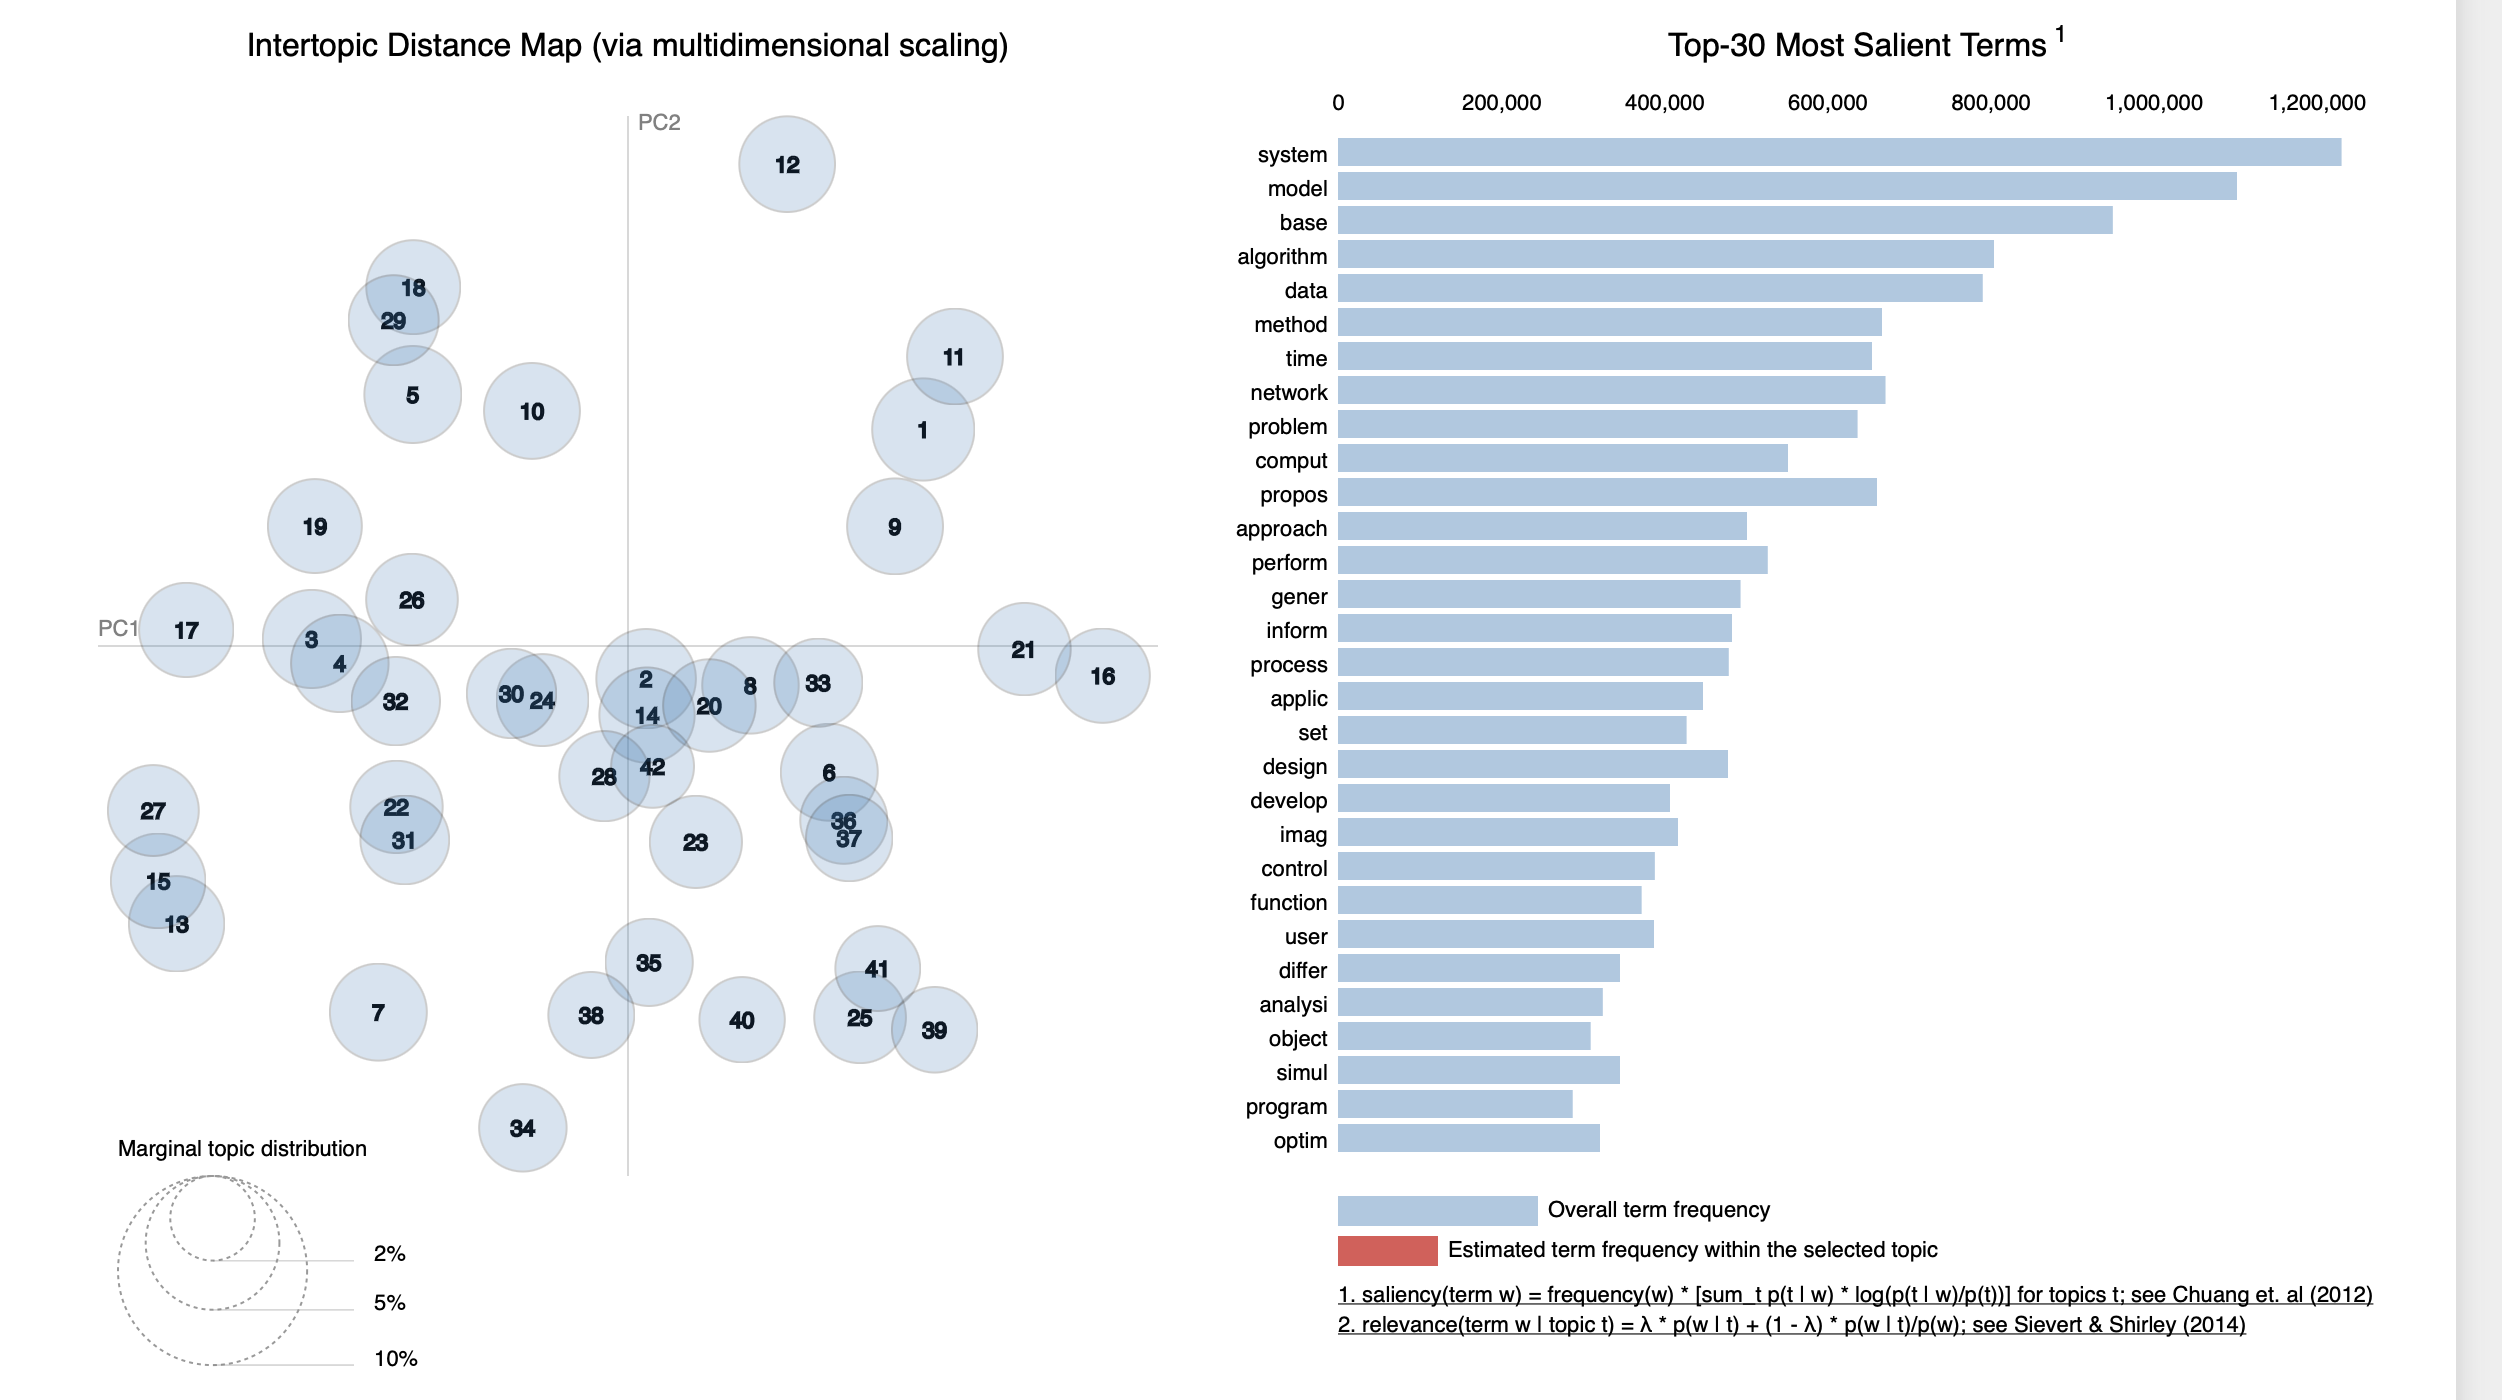

<pre>
    14. Используя pyLDAvis, было замечено хорошее распредедение, но 36 кластер и 37 как-будто можно соединить, для этого проделан дальнейший анализ.
    15. Размечен датасет тегами используя LDAMallet и просмотрено распределдение keywords и fos внутри каждого кластера
    16. Распределение каждого кластера очень понравилось экспертам, а также было выявлено, что 36 и 37 кластер соединять нельзя
    17. Для более удобного осознания были отправлены распределения keywords и fos в разрезе кластера экспертам, с целью дать название каждому кластеру а также для более детального ознакомления
    18. Т.к. LDAMallet написанная на java долго предсказывала кластеры, она была транспортирована в LDA gensim.
</pre>

Другая модель классификации на строилась, т.к. в нашем представлении классификация новых статей будет проходить примерно так:
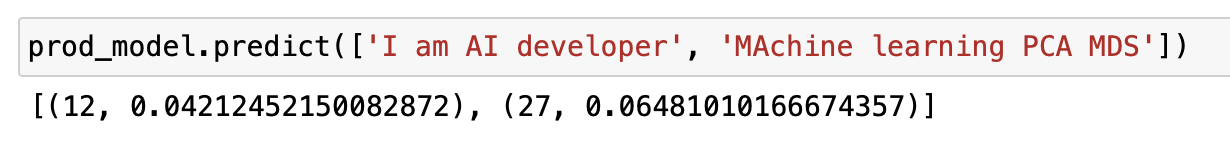

Как итог, моделью полностью довольны